# Modelo basado en n-gramas

Comenzaremos con una implementación basada en *Cavnar, W. B., \& Trenkle, J. M. (1994). N-Gram-Based Text Categorization.*

**Idea:**
- **Entrenamiento**: Entrenar el método es construir los perfiles de cada uno de los idiomas en base a nuestro corpus. Un perfil de un idioma es la frecuencia de los n-gramas que más veces han aparecido en nuestro corpus (en el paper original se quedan con los 300 primeros). Se usan los n-gramas de longitud 1 hasta n (en el paper original se toma n=5).

- **Predicción**: Para predecir un nuevo texto primero se obtiene el perfil de n-gramas de este. Después se compara con los que conocemos, empleando la distancia "out-of-place", básicamente comparando el orden de los n-gramas del perfil. Y se le asigna el idioma con la menor distancia.

- **Preprocesamiento**:
    > Split the text into separate tokens consist
    > ing only of letters and apostrophes. Digits
    > and punctuation are discarded. Pad the
    > token with sufficient blanks before and after.

    - Pasar todo a minúscula
    - No se eliminan los espacios
    - Eliminar los números y signos de puntuación (manteniendo los apóstrofes)

In [40]:
# Librerías necesarias
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import os
import time
from typing import List, Dict, Union
import joblib
import pickle
from utils import classification_metrics_report

## 1. Definición del modelo

Definimos la clase para el modelo de N-gramas con los métodos `fit` y `predict`. He optado por incluir el preprocesamiento como un método (`_preprocess_texts`) dentro de la clase al que se llama de forma automática al entrenar el modelo y hacer predicciones. De esta forma, evitamos inconsistencias y queda todo mejor encapsulado, ya que el preprocesamiento de este modelo es particular en coparación con el que emplearemos para los otros.

In [33]:
class NGramLanguageIdentifier:
    """
    Clase con una implementación de un modelo modelo de detección automática de 
    idiomas basado en N-gramas inspirado en
    Cavnar, W. B., & Trenkle, J. M. (1994). N-Gram-Based Text Categorization

    Args:
    - n: Tamaño máximo de los n-gramas a emplear. Se emplean los n-gramas de 
         tamaño 1 hasta n (por defecto 5)
    - top_k: Tamaño del perfil de n-gramas construido (por defecto 300)

    """
    def __init__(self, n: int = 5, top_k: int = 300):
        self.n = n
        self.top_k = top_k
        self.language_profiles: Dict[str, Dict[str, int]] = {}

    def _get_ngrams(self, text: str, n: int) -> List[str]:
        """ 
        Obtener todos los n-gramas de longitud n de text. 
        Se aplica padding de acuerdo al artículo.
        """
        # Se transforman todos los carácteres de espacio `[ \t\n\r\f\v]` a un espacio
        text = re.sub(r'\s+', ' ', text)
        # Se eliminan los espacios al principio y al final
        text = text.strip()
        # Se añade padding al principio y al final (estandarizar)
        text = ' ' * (n - 1) + text + ' ' * (n - 1)
        # Se devuelven los n-gramas 
        return [text[i:i+n] for i in range(len(text) - n + 1)]

    def _build_profile(self, texts: List[str]) -> Dict[str, int]:
        """
        Construir el perfil de n-gramas en base a los textos de texts.
        Se consideran todos los n-gramas de longitud 1 hasta self.n
        """
        ngram_counter = Counter()
        for i in range(1, self.n + 1):
            for text in texts:
                ngram_counter.update(self._get_ngrams(text.lower(), i))
        most_common = ngram_counter.most_common(self.top_k)
        return {ngram: rank for rank, (ngram, _) in enumerate(most_common)}

    def _rank_order_distance(self, profile1: Dict[str, int], profile2: Dict[str, int]) -> int:
        """"
        Devuelve la distancia "out of place" entre los perfiles profile1 y profile2.
        """
        # El término de penalización creo que es la diferencia máxima
        penalty = len(profile2) + 1

        distance = 0
        for ngram in profile1:
            if ngram in profile2:
                # Si el n-grama está en el profile2, se suma la diferencia en la posición
                distance += abs(profile1[ngram] - profile2[ngram])
            else:
                # Si no se le suma un término de penalización
                distance += penalty
        return distance
    
    def _preprocess_texts(self,texts: List[str]) -> List[str]:
        """
        Preprocesamiento necesario para el modelo
        """
        cleaned_texts = []
        for text in texts:
            # Convertir a minúsculas
            text = text.lower()
            # Eliminar todo lo que no sea letra unicode, espacio o apóstrofo (dejando un espacio)
            text = re.sub(r"[^\p{L}\s']", ' ', text)
            # Eliminar guiones bajos (porque \w incluye _)
            text = re.sub(r'_', '', text)
            # Convertir espacios múltiples en uno solo
            text = re.sub(r'\s+', ' ', text).strip()

            cleaned_texts.append(text)
        return cleaned_texts

    def fit(self, train_texts:List[str], y_train:List[str]) -> None:
        """
        Construir los perfiles de n-gramas para cada idioma
        """
        # Preprocesamos los datos
        train_texts = self._preprocess_texts(train_texts)

        # Agrupar los datos por idioma
        training_data = defaultdict(list)
        for text, label in zip(train_texts, y_train):
             training_data[label].append(text)

        # Construir los perfiles para cada idioma
        self.language_profiles = {
            lang: self._build_profile(texts)
            for lang, texts in training_data.items()
        }

    def predict(self, test_texts:Union[str, List[str]], distances:bool=False) -> Union[str, List[str]]:
        """
        Predecir un nuevo texto o lista de textos. Si es un solo texto
        también se pueden devolver las distancias (inversas del score)
        """

        # Si es una sola cadena, convertirla a lista temporalmente
        is_single = isinstance(test_texts, str)
        if is_single:
            test_texts = [test_texts]

        # Preprocesamos los datos
        test_texts = self._preprocess_texts(test_texts)

        predictions = []    
        for text in test_texts:
            # Se construye el perfil del nuevo texto
            test_profile = self._build_profile([text])
            # Se mide la distancia a los perfiles aprendidos
            distances = {
                lang: self._rank_order_distance(test_profile, profile)
                for lang, profile in self.language_profiles.items()
            }
            # Se devuelve el mínimo de la distancia
            predicted = min(distances, key=distances.get)
            predictions.append(predicted)

        if is_single:
            return distances if distances else predictions[0]
        
        else:
            return  predictions


## 2. Aplicación del modelo

### Lectura de los datos
Comenzamos leyendo las particiones de entrenamiento y test que habíamos creado previamente. En este caso no vamos a hacer ajuste de hiperparámetros por lo que no vamos a emplear el conjunto de validación.

In [34]:
# Leemos los datos
df_train = pd.read_csv(os.path.join("data","raw","train.csv"))
df_test = pd.read_csv(os.path.join("data","raw","test.csv"))

# Veamos nuestro DataFrame
print(df_train.head(5))

# Separamos las variables que usaremos
train_texts = df_train["text"]
test_texts = df_test["text"]

y_train = df_train["language"]
y_test = df_test["language"]

                                                text language  n_words
0   Jeśli chcecie dziś się zbłaźnić, to zapraszam.\n       pl        7
1  Los hombres estaban en el frente por aquel ent...       es        9
2  Ορθώς, επειδή η αρχική πρόταση απέβλεπε μόνο σ...       el       10
3  De modo que en ese sentido hay un claro equili...       es       10
4  V tem kontekstu moramo izpostaviti kmetijski s...       sl        7


### Entrenamiento del modelo
Definimos y entrenamos el modelo. Dado que hemos incluido el preprocesamiento dentro del modelo, no tenemos que preocuparnos por hacerlo previamente.

In [35]:
# Definimos el modelo
ngrams = NGramLanguageIdentifier(n=5, top_k=1000)

# Lo entrenamos
ngrams.fit(train_texts, y_train)

Vamos a guardar el modelo entrenado

In [5]:
# Creamos el directorio si no existe
ngram_dir = os.path.join("models","n-grams")
os.makedirs(ngram_dir, exist_ok=True)

# Guardamos el modelo entrenado
joblib.dump(ngrams, os.path.join(ngram_dir,'ngrams_model.joblib'))

['models\\n-grams\\ngrams_model.joblib']

Veamos un ejemplo de cómo cargarlo posteriormente:

In [6]:
# # Cargar el modelo guardado
# loaded_model = joblib.load(os.path.join(ngram_dir,'ngrams_model.joblib'))

# # Usar el modelo cargado
# loaded_model.predict("Bonjour à tous")

### Evaluación del modelo
Empleamos el modelo para hacer predicciones sobre el conjunto de test y evaluamos su rendimiento

In [37]:
start = time.time()

# Hacemos las predicciones
preds = ngrams.predict(test_texts)
end = time.time()
latency_ms = (end - start) * 1000  # milisegundos

# Empleamos una función personalizada para ver un report del rendimiento
results_ngram = classification_metrics_report(y_test, preds, df_test["n_words"])
print(f"Latencia: {latency_ms:.2f} ms")


=== Global Metrics ===
 accuracy  precision_macro  recall_macro  f1_macro
 0.990557         0.990554      0.990527   0.99053

=== Per-Class Metrics ===
label  precision   recall       f1  support
   cs   1.000000 0.987535 0.993728      722
   da   0.981358 0.987936 0.984636      746
   de   0.997372 0.996063 0.996717      762
   el   1.000000 0.994543 0.997264      733
   es   0.976712 0.980743 0.978723      727
   fi   0.998728 1.000000 0.999363      785
   fr   0.992136 0.997365 0.994744      759
   it   0.989276 0.995951 0.992603      741
   pl   0.994543 0.990489 0.992512      736
   pt   0.982667 0.977454 0.980053      754
   sl   0.983979 0.994602 0.989262      741
   sv   0.989873 0.983648 0.986751      795

=== Metrics Per Size ===
  size  accuracy  precision_macro  recall_macro  f1_macro
 large  0.999635         0.999653      0.999638  0.999644
medium  0.996881         0.996909      0.996900  0.996901
 small  0.960586         0.959667      0.960054  0.959672

=== Confusion Mat

- El modelo funciona muy bien, lo cual hay que sumar a lo simple y rápido que es. 
- Al aumentar el tamaño del perfil de ngramas mejora significativamente el rendimiento del modelo.
- Donde más fallos se producen es entre el español y el portugués y entre el sueco y el danés, ambos casos en los que habíamos visto que hay muchas palabras comunes. 
- A medida que aumenta el tamaño de las frases, aumenta el rendimiento del modelo como es de esperar, pero con frases de tamaño medio (7 a 12 palabras), el modelo tiene un rendimiento excelente.
- Tanto el checo como el griego tienen una precisión de 1, es decir, en estos idiomas no hay falsos positivos. Cuando el modelo dice que una frase está en uno de estos idiomas no se equivoca. Esto es de esperar, ya que son idiomas muy caracteríscos, en especial el griego que tiene un alfabeto diferente.
- El finés tiene un recall de 1, esto significa que no hay falsos negativos. Cuando aparece algo en finés, el modelo lo detecta perfectamente. Esto tampoco nos sorprende porque es un idioma bastante característico e incluso tiene letras propias.

In [8]:
# Guardamos los resultados
with open(os.path.join(ngram_dir,"results.json"), "wb") as f:
    pickle.dump(results_ngram, f)

# Para cargarlo
# with open(os.path.join(ngram_dir,"results.json"), "rb") as f:
#     results_ngram = pickle.load(f)

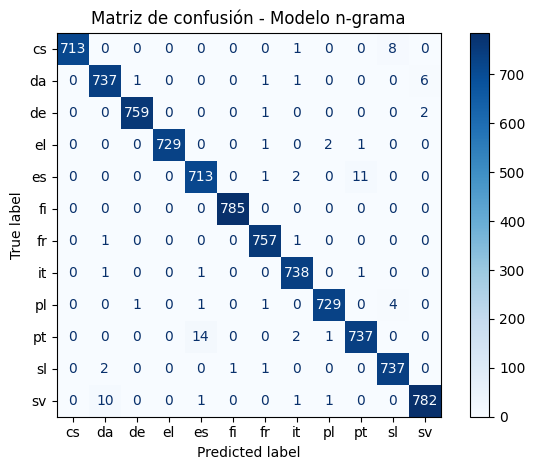

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = results_ngram["confusion_matrix"].values
labels = results_ngram["confusion_matrix"].index.tolist()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Modelo n-grama")
plt.tight_layout()
plt.show()

### Análisis de errores
Veamos donde se equivoca el modelo

In [ ]:
# Esta función nos transformará las distancias en scores, lo cual será útil de cara
# a entender los errores del modelo

def distances2scores(distances: dict) -> dict:
    """
    Convierte distancias en scores usando el inverso (1/d),
    y normaliza para que sumen 1 (tipo distribución de probabilidad).

    Args:
        distances (dict): Diccionario de distancias (valores > 0).

    Returns:
        dict: Scores normalizados (más cercanos → mayor score).
    """
    # Evitar división por cero
    eps = 1e-8
    inv = {k: 1 / (v + eps) for k, v in distances.items()}
    total = sum(inv.values())
    
    scores = {k: round(v / total, 3) for k, v in inv.items()}

    # Lo devolvemos ordenado en orden decreciente
    return dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))

In [11]:
# Nos centramos en los errores
df_errors = df_test[preds!=y_test].copy()

# Añadimos la clase predicha
df_errors.loc[:,"pred"] = [pred for pred, true in zip(preds, y_test) if pred != true]

# Añadimos el rank
df_errors.loc[:,"scores"] = [distances2scores(ngrams.predict(text,distances=True)) for i, text in enumerate(test_texts) if preds[i]!=y_test[i]]

# Añadimos la frase preprocesada
df_errors.loc[:,"preprocessed_text"] = [ngrams._preprocess_texts([text])[0] for i, text in enumerate(test_texts) if preds[i]!=y_test[i]]

# Veamos los errores
df_errors

,text,language,n_words,pred,scores,preprocessed_text
166,E' importante dirlo.\n,it,3,es,"{'es': 0.102, 'it': 0.1, 'pt': 0.099, 'fr': 0....",e' importante dirlo
394,"(La sesión, suspendida a las 13.10 horas, se r...",pl,11,es,"{'es': 0.11, 'pt': 0.091, 'fr': 0.088, 'it': 0...",la sesión suspendida a las horas se reanuda a ...
681,Han fyllde visst år i går.\n,sv,6,da,"{'da': 0.101, 'sv': 0.099, 'de': 0.086, 'fr': ...",han fyllde visst år i går
740,"Primero vamos a votar el corrigendum nº 1, par...",es,14,pt,"{'pt': 0.097, 'es': 0.096, 'it': 0.09, 'sl': 0...",primero vamos a votar el corrigendum nº para v...
903,- Έκθεση Costa\n,el,2,pt,"{'pt': 0.09, 'it': 0.09, 'es': 0.088, 'fi': 0....",έκθεση costa
...,...,...,...,...,...,...
8585,Está encerrado o debate.\n,pt,4,es,"{'es': 0.105, 'pt': 0.103, 'it': 0.087, 'fr': ...",está encerrado o debate
8660,To bezdyskusyjne.\n,pl,2,sl,"{'sl': 0.097, 'pl': 0.096, 'cs': 0.096, 'da': ...",to bezdyskusyjne
8708,Hvala lepa.\n,sl,2,fi,"{'fi': 0.091, 'es': 0.089, 'sl': 0.089, 'it': ...",hvala lepa
8759,Terrorism i Spanien\n,sv,3,pl,"{'pl': 0.089, 'de': 0.088, 'sv': 0.088, 'da': ...",terrorism i spanien


- El dataset original contiene errores: 
    - "(La sesión, suspendida a las 13.10 horas, se reanuda a las 15.00 horas)" aparece como polaco.
    - "(The sitting closed at 16.35) parece como esloveno
    - "Program Marco Polo II (" aparece como checo.
    - "because [he has] nothing else here for you," aparece como esloveno.
- Hay frases muy complicadas o casi imposibles:
    - "(10419/1/2001 - C5-0417/2001 - 2000/0188(COD)) (Εισηγήτρια: κ. Niebler)" es griega, pero solo tiene una palabra en griego
    - "ECU 870 millioner." es danés.
- Casos en los que por la forma en la que trabaja el modelo, es comprensible el error:
    - "Está encerrado o debate." es portuguesa y se clasifica como español. La única diferencia es el "o". Es un caso complicado, habría que usar algún mecanismo de atención.
- Frases comunes en distintas lenguas:
    - "Al contrario!" aparece como italiano, pero podría ser español. Diferencia en el uso de los signos de puntuació en los distintos idiomas.
- Cuando el modelo se equivoca, suele haber muy poca diferencia en los scores entre el idioma correcto y el idioma predicho


### Pruebas
Hacemos algunas pruebas para ver el funcionamiento del modelo

In [46]:
ngrams.predict("Hola buenos días") # Español

'es'

In [47]:
ngrams.predict("Cómo") # Español

'it'

In [48]:
ngrams.predict("Nicht") # Alemán 

'de'

In [49]:
ngrams.predict("Ça ne marche pas") # Francés 

'fr'

In [50]:
ngrams.predict("Ça ne marche pas, je suis desolé") # Francés 

'fr'

In [51]:
ngrams.predict("Det fungerar inte.") # Sueco

'sv'

In [ ]:
ngrams.

## 3. Aumentamos el tamaño del perfil de ngramas por idioma
Si aumentamos el tamaño del perfil de n-gramas de 1000 a 5000 el rendimiento del modelo se dispara, pero aumentan también su latencia.

In [ ]:
# Definimos el modelo
ngramsXL = NGramLanguageIdentifier(n=5, top_k=5000)

# Lo entrenamos
ngramsXL.fit(train_texts, y_train)

Vamos a hacer las predicciones sobre el conjunto test miendo el tiempo que tarda

In [41]:
import time

start = time.time()
# Hacemos las predicciones
preds = ngramsXL.predict(test_texts)
end = time.time()

latency_ms = (end - start) * 1000  # milisegundos
print(f"Latencia: {latency_ms:.2f} ms")

Latencia: 3738.64 ms


In [42]:
# Empleamos una función personalizada para ver un report del rendimiento
results_ngramXL = classification_metrics_report(y_test, preds, df_test["n_words"])

=== Global Metrics ===
 accuracy  precision_macro  recall_macro  f1_macro
 0.997111          0.99711      0.997094    0.9971

=== Per-Class Metrics ===
label  precision   recall       f1  support
   cs   1.000000 0.995845 0.997918      722
   da   0.993307 0.994638 0.993972      746
   de   0.997379 0.998688 0.998033      762
   el   1.000000 1.000000 1.000000      733
   es   0.993132 0.994498 0.993814      727
   fi   1.000000 1.000000 1.000000      785
   fr   0.994758 1.000000 0.997372      759
   it   0.995962 0.998650 0.997305      741
   pl   0.997283 0.997283 0.997283      736
   pt   0.996016 0.994695 0.995355      754
   sl   1.000000 0.994602 0.997294      741
   sv   0.997481 0.996226 0.996853      795

=== Metrics Per Size ===
  size  accuracy  precision_macro  recall_macro  f1_macro
 large  1.000000         1.000000      1.000000  1.000000
medium  0.999332         0.999325      0.999325  0.999324
 small  0.987050         0.986765      0.986885  0.986788

=== Confusion Mat

Medimos la latencia del modelo que proponen en el paper con tamaño 600

In [43]:
# Definimos el modelo
ngramsS = NGramLanguageIdentifier(n=5, top_k=600)

# Lo entrenamos
ngramsS.fit(train_texts, y_train)

Vamos a hacer las predicciones sobre el conjunto test miendo el tiempo que tarda

In [44]:
import time

start = time.time()
# Hacemos las predicciones
preds = ngramsS.predict(test_texts)
end = time.time()

latency_ms = (end - start) * 1000  # milisegundos
print(f"Latencia: {latency_ms:.2f} ms")

Latencia: 2743.30 ms


In [45]:
# Empleamos una función personalizada para ver un report del rendimiento
results_ngramS = classification_metrics_report(y_test, preds, df_test["n_words"])

=== Global Metrics ===
 accuracy  precision_macro  recall_macro  f1_macro
 0.985335         0.985423      0.985289  0.985337

=== Per-Class Metrics ===
label  precision   recall       f1  support
   cs   1.000000 0.983380 0.991620      722
   da   0.975839 0.974531 0.975184      746
   de   0.994709 0.986877 0.990777      762
   el   1.000000 0.993179 0.996578      733
   es   0.963165 0.971114 0.967123      727
   fi   0.997459 1.000000 0.998728      785
   fr   0.989474 0.990777 0.990125      759
   it   0.986577 0.991903 0.989233      741
   pl   0.994536 0.989130 0.991826      736
   pt   0.973298 0.966844 0.970060      754
   sl   0.977454 0.994602 0.985953      741
   sv   0.972569 0.981132 0.976832      795

=== Metrics Per Size ===
  size  accuracy  precision_macro  recall_macro  f1_macro
 large  0.998538         0.998578      0.998578  0.998578
medium  0.993985         0.994107      0.993984  0.994041
 small  0.943131         0.942306      0.942352  0.941954

=== Confusion Mat